# Multi-Element Airfoil

In [1]:
import numpy as np
import pandas as pd

import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

import logging

logging.getLogger().setLevel(logging.INFO)

matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

In [2]:
interactive_plot = True

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

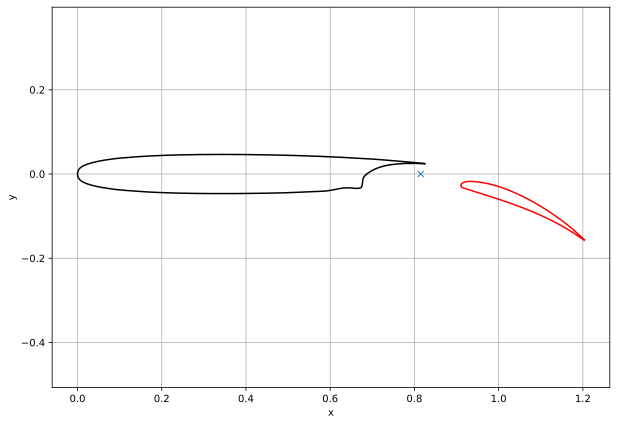

In [3]:
# Read and panel airfoil data
MAIN = vft.read_selig("airfoils/main_element.dat")[:, ::-1]
MAIN = vft.repanel(MAIN, N=200)  # 180

# MAIN = vft.repanel(vft.read_selig("airfoils/NLR7301MainECARP.dat"), N = 200)[:,::-1] #180

# FLAP0 = vft.read_selig("airfoils/flap.dat")
# FLAP0 = vft.repanel(FLAP0, N=200)[:, ::-1]  # 180
# FLAP0 = vft.repanel(vft.read_selig("airfoils/NLR7301FlapECARP.dat"), N = 220)[:,::-1] #150
# _min = FLAP0[0].min()
# FLAP0[0,:] += -_min

FLAP00 = vft.repanel(vft.read_selig("airfoils/NLR7301FlapECARP.dat"), N=220)[:, ::-1]
_min = FLAP00[0].min()
FLAP00[0, :] += -_min


def rotate(deg, center, x):
    """Rotate airfoil.

    Parameters
    ----------
    deg : float
    center : numpy.array
    x : numpy.array

    Returns
    -------
    moved : numpy.array
    """

    # Create rotation matrix
    deg2rad = np.pi / 180
    c, s = np.cos(deg * deg2rad), np.sin(deg * deg2rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.
    moved = ((A @ ((x.T - center.T).T)).T + center.T).T
    # moved = ((A @ ((x.T).T)).T).T

    return moved


# Rotate flap
HINGE = 0.8 + 0.015
center = np.r_[HINGE, 0.0]

#FLAP0[0, :] += HINGE
#FLAP = rotate(20, center, FLAP0)
#FLAP[1, :] += 0.02

FLAP00[0, :] += HINGE
FLAP1 = rotate(10, center, FLAP00)
FLAP1[1, :] += 0.0
FLAP1[0, :] += 0.1

# Plot geometry
fig, ax = plt.subplots(1, 1)
ax.plot(MAIN[0, :], MAIN[1, :], "-k")
# ax.plot(FLAP[0, :], FLAP[1, :], "-b")
ax.plot(FLAP1[0, :], FLAP1[1, :], "-r")
ax.plot(center[0], center[1], marker="x")
ax.axis("equal")
ax.grid()
ax.set(xlabel="x", ylabel="y")

<IPython.core.display.Javascript object>


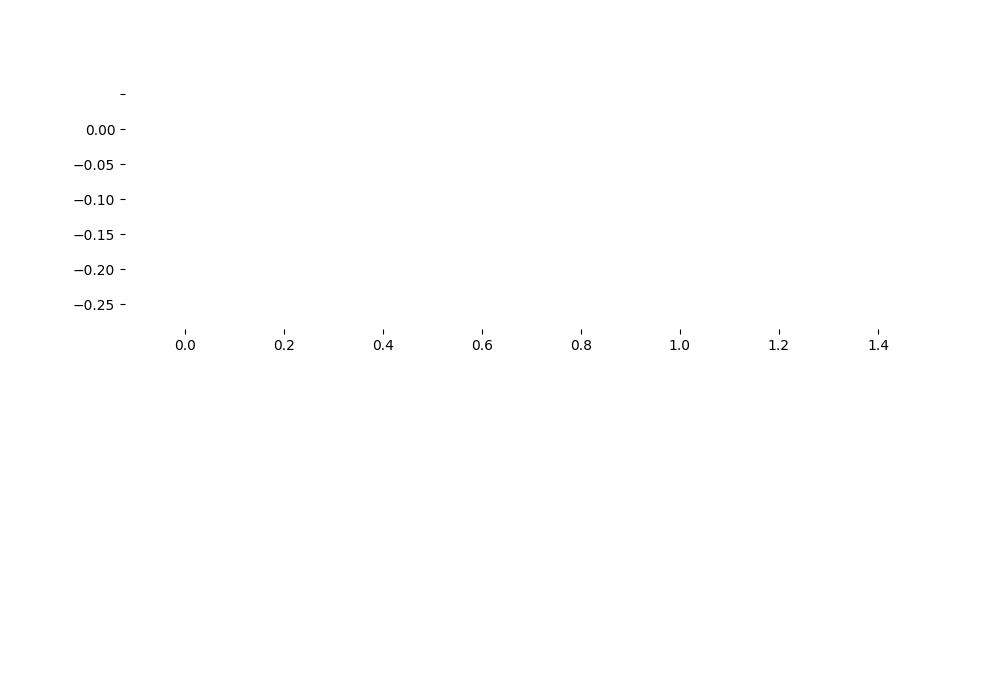

In [4]:
if interactive_plot:
    %matplotlib notebook
    matplotlib.rcParams['figure.figsize'] = [10, 7] 
    lines = None
    fig, axes = plt.subplots(2,1)
    
    axes = axes.flatten()
    
    ax_airfoil = axes[0]
    ax_residual = axes[1]
    
else:
    %matplotlib inline
    matplotlib.rcParams['figure.figsize'] = [12, 6]
%config InlineBackend.figure_format = 'svg'

In [5]:
# BASE = vft.repanel(vft.read_selig("S1210Base.dat"),230)
# SLOT = vft.repanel(vft.read_selig("S1210Slot.dat"),200)
# SLOT0 = vft.read_selig("S1210Slot0.dat") # Actual slot shape


# Virtual displacement
[vdFlap, FLAPD] = vft.virtual_displacement_from_geometry(FLAP1, FLAP1)
vdFlap[0] = 0.0
vdFlap[-1] = 0.0

AOARANGE = [-8.08, 0.01, 8.93]

# Setup
RE = 1e8
ncrit = 9
Mach = 0.0

In [6]:
AOA0 = AOARANGE[-1]

s = vf.setup(Re=RE, Ma=Mach, Ncrit=ncrit, Alpha=AOA0)

s.IterateWakes = True
s.Itermax = 1
s.Silent = True
s.Tolerance = 1e-3

# Set-up and initialize based on inviscid panel solution
(p, bl, xn) = vf.init([MAIN, FLAP1], s)

# Plot geometry
if interactive_plot:
    lines = vfp.plot_geometry(ax_airfoil, p, bl, lines)

d:\envs\high_lift\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
d:\envs\high_lift\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
# xn = x.copy()
alv = []
clv = []
cdv = []

for alpha in AOARANGE:
    
    s = vf.setup(Re=RE, Ma=Mach, Ncrit=ncrit, Alpha=AOA0)

    s.IterateWakes = True
    s.Itermax = 1
    s.Silent = True
    s.Tolerance = 1e-3
    s.StepsizeLimit = 0.05 # Restricting the stepsize is beneficial here for some AOA
    s.IncompressibleBL = 1

    s.Alpha = alpha
    
    # Set-up and initialize based on inviscid panel solution
    (p, bl, xn) = vf.init([MAIN, FLAP1], s)

    res = None
    grad = None

    residual_path = []
    
    num = int(500 / s.Itermax)
    for iteration in range(num):

        # Make effectively 100 iterations, but show some in between
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, s, res, grad, [None, vdFlap])

        # Compute residual
        nres = np.sqrt(np.dot(res.T, res))
        residual_path.append(nres)
        
        # Plot geometry
        if interactive_plot:
            lines = vfp.plot_geometry(ax_airfoil, p, bl, lines)
            _ = ax_residual.plot(residual_path)
            ax_residual.set_yscale('log')

        title_airfoil = f"AOA={alpha}, Iter={iteration}" 
        title_residual = f"RES={nres}" 

        ax_airfoil.set_title(title_airfoil)
        ax_residual.set_title(title_residual)

        fig.canvas.draw()

        if flag:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD + bl[1].CD)
            print("AL: %f CL: %f CD: %f" % (alpha, clv[-1], cdv[-1]))
            break

d:\envs\high_lift\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
 xi=0.413613,delta=0.011324,theta=0.004219,ue=0.901186,typ=wake,
 res=[-0.000123514,0.000521692,1.71315e-06]
 dx=[-8.0212e-05,0.00353759,-0.00032519]
 x=[0.00421947,0.901186,0.0914089] 
 lam=1.000000 H=2.683648 HS=1.506687 US=0.183913.



AL: -8.080000 CL: 0.627474 CD: 0.014980


 xi=0.045474,delta=0.000004,theta=0.000002,ue=7.876500,typ=turbulent,
 res=[0.468259,-0.971614,-0.000183883]
 dx=[-1.59562e-06,2.23505,0.00289734]
 x=[2.23319e-06,7.8765,0.0155327] 
 lam=0.349894 H=1.781983 HS=1.640046 US=0.386471.

 xi=0.045455,delta=0.000002,theta=0.000001,ue=11.525917,typ=turbulent,
 res=[1.10439,-1.36122,-0.000176494]
 dx=[-1.33422e-06,4.33032,0.00296338]
 x=[1.19116e-06,11.5259,0.0114187] 
 lam=0.223194 H=2.004521 HS=1.596812 US=0.316354.

 xi=0.045430,delta=0.000001,theta=0.000001,ue=15.926932,typ=turbulent,
 res=[-0.290211,-0.555432,0.000299612]
 dx=[-1.30972e-07,4.68497,-0.00147009]
 x=[8.89319e-07,15.9269,0.00681149] 
 lam=0.566596 H=1.610922 HS=1.692297 US=0.459533.

 xi=0.045428,delta=0.000001,theta=0.000000,ue=33.088899,typ=turbulent,
 res=[1.98193,-1.19959,-1.81393e-05]
 dx=[-8.02661e-08,4.80719,-6.87478e-05]
 x=[4.31811e-07,33.0889,0.00397988] 
 lam=1.000000 H=1.990625 HS=1.598561 US=0.320054.

 xi=0.045426,delta=0.000002,theta=0.000001,ue=15.523717,typ=t

KeyboardInterrupt: 

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [ ]:
# Settings
RE = 1e6
ncrit = 8
MACH_0 = 0.1

# Angle of Attack
AOA_start = -1
AOA_stop = 7.5
N = 7
# AOArange = np.linspace(start = AOA_start, stop = AOA_stop, num = N)
AOArange = [-8.08, 0.01, 8.93]

# Prepare problem
# setup = vf.setup(Re=RE, Ncrit=ncrit, Ma=MACH_0, Itermax=500, IterateWakes=False, Substeps = 5, HalfWakes = False)
setup = vf.setup(Re=RE, Ncrit=ncrit, Ma=MACH_0, Itermax=150)
setup.Silent = True  # Do not show information on convergence and iterations

# RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
# setup.ShearLagType = 2

results = {}  # Dictionary of results

#  Set Mach number
setup.Ma = MACH_0

results = {}
results["AOA"] = []
results["CL"] = []
results["CLi"] = []
results["CD"] = []

elements = [MAIN, FLAP]
# elements = [FLAP]
# elements = [MAIN]

for alpha in AOArange:

    # When using an outer loop, make sure to re-initialize the solution
    Init = True

    setup.Alpha = alpha
    print(f"alpha: {alpha}")

    if Init:
        [p, bl, xn] = vf.init(elements, setup)
        Init = False

    res = None
    grad = None
    [xn, flag, res, grad, _] = vf.iter(xn, bl, p, setup, res, grad)

    if bool(flag) == True:
        results["AOA"].append(alpha)
        results["CL"].append(p.CL)
        results["CLi"].append(p.CLi)
        results["CD"].append(bl[0].CD)
        print("AOA %2.2f CL %f" % (alpha, p.CL))

In [ ]:
results_df = pd.DataFrame(results).set_index("AOA")

results_df.plot(subplots=True, grid=True, marker="x")

---

In [ ]:
# Read experimental data
EXPRES = np.genfromtxt("NLRLIFTSLOPE.csv", delimiter=",", names=True)

fix, ax = plt.subplots(1, 2)
ax[0].plot(
    EXPRES["MEAS_X"],
    EXPRES["MEAS_Y"],
    marker=".",
    linestyle="None",
    color="tab:blue",
    label="Experimental Lift",
)
for val in Mach_vec:
    ax[0].plot(
        np.array(results[val]["AOA"]),
        np.asarray(results[val]["CL"]),
        marker=None,
        label="Calculation Mach %g" % val,
    )
ax[0].plot(
    np.array(results[val]["AOA"]),
    results[val]["CLi"],
    marker=None,
    label="Inviscid Lift",
)

ax[0].set_xlabel("AOA")
ax[0].set_ylabel("CL")
ax[0].legend()
ax[0].set_xlim([-2, 17])
ax[0].set_ylim([1.5, 3.5])

EXPRESD = np.genfromtxt("NLRDRAGSLOPE.csv", delimiter=",", names=True)
ax[1].plot(
    EXPRESD["MEAS_X"],
    EXPRESD["MEAS_Y"],
    marker=".",
    linestyle="None",
    color="tab:blue",
    label="Experimental Drag",
)
for val in Mach_vec:
    ax[1].plot(
        results[val]["AOA"],
        results[val]["CD"],
        marker=None,
        label="Calculation Mach %g" % val,
    )

ax[1].set_ylim([0, 0.08])
ax[1].set_xlim([-2, 17])
ax[1].set_xlabel("AOA")
ax[1].set_ylabel("CD")
ax[1].legend()

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [ ]:
# Set-up and initialize based on inviscid panel solution
s.Ma = 0.0

# Experimental 6° has the same lift as numerical 5.5°
s.Alpha = 6
[p6, bl6, x] = vf.init([MAIN, FLAP], s)
[x, flag, res, _, _] = vf.iter(x, bl6, p6, s, None, None)

# Experimental 13.1° has the same lift as numerical 12.6°
s.Alpha = 13.1
[p13, bl13, _] = vf.init([MAIN, FLAP], s)
[x, flag, res, _, _] = vf.iter(x, bl13, p13, s, None, None)

In [ ]:
# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax, EXPRES):
    ax.plot(
        EXPRES["EXPMAINCP_X"],
        EXPRES["EXPMAINCP_Y"],
        marker="o",
        linestyle="None",
        color="tab:blue",
        label="Experiment",
    )
    ax.plot(
        EXPRES["EXPFLAPCP_X"] + 0.1,
        EXPRES["EXPFLAPCP_Y"],
        marker="o",
        linestyle="None",
        color="tab:blue",
    )
    ax.plot(
        EXPRES["EXPMAINTR_X"],
        EXPRES["EXPMAINTR_Y"],
        marker="D",
        linestyle="None",
        color="tab:orange",
        label="Experimental transition region",
    )
    ax.plot(
        EXPRES["EXPFLAPTR_X"] + 0.1,
        EXPRES["EXPFLAPTR_Y"],
        marker="D",
        linestyle="None",
        color="tab:orange",
    )


# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax, p, bl):
    # A helper index, cp is a single array of pressures over all panel nodes
    IMF = [range(0, p.foils[0].N), range(p.foils[0].N, p.foils[0].N + p.foils[1].N)]

    ax.plot(
        np.array(p.foils[0].X[0, :]),
        -p.cp[IMF[0]],
        marker="None",
        color="tab:blue",
        label="Viscous calculation",
    )
    ax.plot(
        np.array(p.foils[1].X[0, :] + 0.1),
        -p.cp[IMF[1]],
        marker="None",
        color="tab:blue",
    )
    ax.plot(
        np.array(p.foils[0].X[0, :]),
        -p.cp_inviscid[IMF[0]],
        ":",
        marker="None",
        color="tab:green",
        label="Inviscid calculation",
    )
    ax.plot(
        np.array(p.foils[1].X[0, :] + 0.1),
        -p.cp_inviscid[IMF[1]],
        ":",
        marker="None",
        color="tab:green",
    )

    for k in range(2):
        tr_lo = np.interp(
            bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
            p.foils[k].S,
            p.foils[k].X[0, :] + k * 0.1,
        )
        tr_up = np.interp(
            bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
            p.foils[k].S,
            p.foils[k].X[0, :] + k * 0.1,
        )
        cp_up = np.interp(
            bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
            p.foils[k].S,
            np.asarray(p.cp[IMF[k]]).ravel(),
        )
        cp_lo = np.interp(
            bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
            p.foils[k].S,
            np.asarray(p.cp[IMF[k]]).ravel(),
        )
        ax.plot(tr_lo, -cp_lo, "v", color="tab:red", label="Numerical transition point")
        ax.plot(tr_up, -cp_up, "v", color="tab:red")

    ax.set_xlabel("x/c")
    ax.set_ylabel("-cp")

In [ ]:
# Read and plot data for 6° AoA
# EXPRES=np.genfromtxt("NLRCP55.csv",delimiter=",",names=True)
fig, ax = plt.subplots(1, 1)
# plot_cp_exp(ax,EXPRES)
plot_cp(ax, p, bl)
ax.set_title("Main Airfoil 6° AOA")
ax.legend()

# Read and plot data for 13.1° AoA
# EXPRES=np.genfromtxt("NLRCP126.csv",delimiter=",",names=True)
fig, ax = plt.subplots(1, 1)
# plot_cp_exp(ax,EXPRES)
plot_cp(ax, p, bl)
ax.legend()

[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 